# Table of Contents

# Problem Statement

The Society of Professional Journalists hired The East-West Alliance (TEWA) as consultants to create a model that predicts and classifies articles as either fake or real based on the title and content of the news article. The goal aims to mitigate the spread of misinformation and promote accountability in the media.  It would help out social media sites like Facebook and Twitter to filter out spam and/or fake stories that would make a culpable person believe them.

# Imports

In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import time
import datetime as dt
import nltk, string, re

## Data Cleaning
from dateutil.parser import parse, ParserError

## Model considerations and downloads
from statsmodels.api import OLS
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier      ## Decision Tree Class
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer

## Train Test Splits and scoring
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error,
                                confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, 
                                roc_auc_score, precision_score, f1_score, recall_score)
from scipy.stats import ttest_ind
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
%matplotlib inline


## NLP Considerations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup

# Read Data

In [311]:
Fake_df = pd.read_csv('./Data/Fake.csv')
Fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [406]:
Fake_df.shape

(23481, 5)

In [313]:
Fake_df['target'] = 1

In [314]:
Fake_df.isna().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [315]:
# The shape does not match the original data file. Original 23502 while loaded shape is 23481
Fake_df.shape 

(23481, 5)

In [316]:
True_df = pd.read_csv('./Data/True.csv')
True_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [317]:
True_df['target'] = 0

In [318]:
True_df.shape

(21417, 5)

In [319]:
# Expected number of records
Fake_df.shape[0] + True_df.shape[0]

44898

In [320]:
# Combine Fake and True Datasets
Full_df = pd.concat([Fake_df,True_df])
Full_df.shape

(44898, 5)

In [321]:
Full_df.reset_index(inplace=True)

In [322]:
Full_df.drop(columns="index", inplace=True)

In [407]:
Full_df.head()

,title,text,subject,date,target,all_text,cleanText,title_char_length,title_word_count,text_char_length,text_word_count,char_per_word_title,char_per_word_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,Donald Trump Sends Out Embarrassing New Year’s...,donald trump wish american happy new year leav...,78,12,1794,260,6.500000,6.900000
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,Drunk Bragging Trump Staffer Started Russian C...,house intelligence committee chairman devin nu...,68,8,1367,178,8.500000,7.679775
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,Sheriff David Clarke Becomes An Internet Joke ...,friday revealed former milwaukee sheriff david...,89,15,2349,321,5.933333,7.317757
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,Trump Is So Obsessed He Even Has Obama’s Name ...,christmas day donald trump announced would bac...,77,14,1785,248,5.500000,7.197581
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,Pope Francis Just Called Out Donald Trump Duri...,pope francis used annual christmas day message...,69,11,1426,211,6.272727,6.758294


In [408]:
Full_df.tail()

,title,text,subject,date,target,all_text,cleanText,title_char_length,title_word_count,text_char_length,text_word_count,char_per_word_title,char_per_word_text
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,0,'Fully committed' NATO backs new U.S. approach...,brussels reuters nato ally tuesday welcomed pr...,61,9,1925,259,6.777778,7.432432
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,0,LexisNexis withdrew two products from Chinese ...,london reuters lexisnexis provider legal regul...,52,7,581,75,7.428571,7.746667
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,0,Minsk cultural hub becomes haven from authorit...,minsk reuters shadow disused sovietera factory...,49,7,1304,169,7.000000,7.715976
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,0,Vatican upbeat on possibility of Pope Francis ...,moscow reuters vatican secretary state cardina...,61,9,837,117,6.777778,7.153846
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,2017-08-22,0,Indonesia to buy $1.14 billion worth of Russia...,jakarta reuters indonesia buy sukhoi fighter j...,52,9,1017,135,5.777778,7.533333


In [409]:
Full_df.shape

(43970, 13)

# Cleaning Data

In [324]:
# Creating a new column to append as a new date column.
new_date = []
for x in range(0, len(Full_df['date'])):
        try:
            bool(parse(Full_df.loc[x]['date'])) # returns True if a cell is in datetime format
        except ParserError:
            new_date.append(np.nan) # runs this line if there is an error
        else:
            new_date.append(Full_df.loc[x]['date']) # this code runs if there is no error

#Try and except: https://www.youtube.com/watch?v=NIWwJbo-9_8&ab_channel=CoreySchafer
#Date Validation: https://www.geeksforgeeks.org/python-validate-string-date-format/
#ParseError Code: https://dateutil.readthedocs.io/en/stable/parser.html#dateutil.parser.ParserError

In [325]:
Full_df['date'] = new_date

In [326]:
Full_df['date'] = pd.to_datetime(Full_df['date'])

In [327]:
Full_df.dtypes

title              object
text               object
subject            object
date       datetime64[ns]
target              int64
dtype: object

In [328]:
# Remove any whitespaces in these columns
Full_df['title'] = Full_df['title'].map(lambda x: x.strip())
Full_df['text'] = Full_df['text'].map(lambda x: x.strip())

In [329]:
# Full_df.to_csv('newdf.csv')

In [330]:
# Reference to the original Full DF
Full_df.shape

(44898, 5)

In [331]:
# Drop Duplicate rows
Full_df.drop_duplicates(inplace = True)
Full_df.shape

(44687, 5)

In [332]:
Full_df.dropna(inplace = True)
Full_df.shape

(44677, 5)

In [333]:
Full_df['target'].value_counts(normalize=True)

1    0.525237
0    0.474763
Name: target, dtype: float64

# Feature Engineering

In [334]:
Full_df["all_text"] = Full_df["title"] + " " + Full_df["text"]

In [335]:
Full_df

,title,text,subject,date,target,all_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,Donald Trump Sends Out Embarrassing New Year’s...
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,Drunk Bragging Trump Staffer Started Russian C...
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,Sheriff David Clarke Becomes An Internet Joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,Trump Is So Obsessed He Even Has Obama’s Name ...
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,Pope Francis Just Called Out Donald Trump Duri...
...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,0,'Fully committed' NATO backs new U.S. approach...
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,0,LexisNexis withdrew two products from Chinese ...
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,0,Minsk cultural hub becomes haven from authorit...
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,0,Vatican upbeat on possibility of Pope Francis ...


In [336]:
stop=set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
wordTokenizer = nltk.tokenize.WhitespaceTokenizer()

def Preprocessing(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(' +',' ',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = BeautifulSoup(text,  features="lxml").text 
    text = re.sub('https?://\S+|www\.\S+', '', text)

    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = ' '.join([lemmatizer.lemmatize(w) for w in wordTokenizer.tokenize(text) if (w not in stop)])
    # text = ' '.join([token.lemma_ for token in list(nlp(text)) if (token.is_stop == False)])
    return text

Full_df['cleanText'] = Full_df['text'].apply(lambda x:Preprocessing(x))

#Source: https://www.kaggle.com/code/mbnhmd/models-comparison-on-true-fake-news-dataset

In [337]:
Full_df["title_char_length"] = Full_df["title"].apply(lambda x: len(x))
Full_df["title_word_count"] = Full_df["title"].apply(lambda x: len(str(x).split()))
Full_df["text_char_length"] = Full_df["cleanText"].apply(lambda x: len(x))
Full_df["text_word_count"] = Full_df["cleanText"].apply(lambda x: len(str(x).split()))
## Create one additional column which is the characters per word in title and text
Full_df["char_per_word_title"] = Full_df["title_char_length"] / Full_df["title_word_count"]
Full_df["char_per_word_text"] = Full_df["text_char_length"] / Full_df["text_word_count"]

In [338]:
Full_df.head()

,title,text,subject,date,target,all_text,cleanText,title_char_length,title_word_count,text_char_length,text_word_count,char_per_word_title,char_per_word_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,Donald Trump Sends Out Embarrassing New Year’s...,donald trump wish american happy new year leav...,78,12,1794,260,6.500000,6.900000
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,Drunk Bragging Trump Staffer Started Russian C...,house intelligence committee chairman devin nu...,68,8,1367,178,8.500000,7.679775
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,Sheriff David Clarke Becomes An Internet Joke ...,friday revealed former milwaukee sheriff david...,89,15,2349,321,5.933333,7.317757
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,Trump Is So Obsessed He Even Has Obama’s Name ...,christmas day donald trump announced would bac...,77,14,1785,248,5.500000,7.197581
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,Pope Francis Just Called Out Donald Trump Duri...,pope francis used annual christmas day message...,69,11,1426,211,6.272727,6.758294


In [339]:
Full_df['text_word_count'].value_counts().sort_values()

863       1
921       1
1685      1
701       1
1377      1
       ... 
52      182
210     184
192     188
181     190
0       707
Name: text_word_count, Length: 1023, dtype: int64

In [340]:
Full_df.drop(Full_df.loc[Full_df['text_word_count'] == 0].index, inplace = True) #Delete the '' rows for text column

In [341]:
Full_df.shape

(43970, 13)

In [342]:
# Full_df.to_csv('fulldf2.csv')

# EDA

In [343]:
Full_df.loc[Full_df['target']==1,:]

,title,text,subject,date,target,all_text,cleanText,title_char_length,title_word_count,text_char_length,text_word_count,char_per_word_title,char_per_word_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,Donald Trump Sends Out Embarrassing New Year’s...,donald trump wish american happy new year leav...,78,12,1794,260,6.500000,6.900000
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,Drunk Bragging Trump Staffer Started Russian C...,house intelligence committee chairman devin nu...,68,8,1367,178,8.500000,7.679775
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,Sheriff David Clarke Becomes An Internet Joke ...,friday revealed former milwaukee sheriff david...,89,15,2349,321,5.933333,7.317757
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,Trump Is So Obsessed He Even Has Obama’s Name ...,christmas day donald trump announced would bac...,77,14,1785,248,5.500000,7.197581
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,Pope Francis Just Called Out Donald Trump Duri...,pope francis used annual christmas day message...,69,11,1426,211,6.272727,6.758294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,1,McPain: John McCain Furious That Iran Treated ...,st century wire say wire reported earlier week...,61,10,2286,306,6.100000,7.470588
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,st century wire say familiar theme whenever di...,81,12,1093,160,6.750000,6.831250
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,patrick henningsen st century wireremember oba...,85,14,16801,2298,6.071429,7.311140
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,1,How to Blow $700 Million: Al Jazeera America F...,st century wire say al jazeera america go hist...,67,12,1786,262,5.583333,6.816794


In [344]:
fake_subject_EDA = pd.get_dummies(columns = ["subject"], data = Full_df, drop_first=False)

In [345]:
Fake_Govt_News = fake_subject_EDA["subject_Government News"].sum()
Fake_ME_News = fake_subject_EDA["subject_Middle-east"].sum()
Fake_News_News = fake_subject_EDA["subject_News"].sum()
Fake_US_News = fake_subject_EDA["subject_US_News"].sum()
Fake_Left_News = fake_subject_EDA["subject_left-news"].sum()
Fake_Politics_News = fake_subject_EDA["subject_politics"].sum()

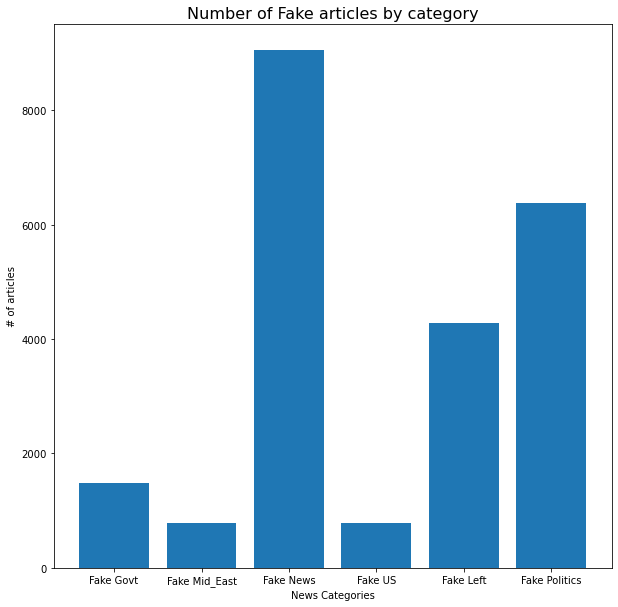

In [346]:
## Define the figure
fig = plt.figure(figsize=(10,10))
Category_Count_XName = ["Fake Govt", "Fake Mid_East", "Fake News", "Fake US", "Fake Left", "Fake Politics"]
Category_Count_Yname = [Fake_Govt_News, Fake_ME_News, Fake_News_News, Fake_US_News, Fake_Left_News, Fake_Politics_News]
plt.bar(Category_Count_XName,
        Category_Count_Yname)

plt.xlabel("News Categories")
plt.ylabel("# of articles")
plt.title("Number of Fake articles by category", fontsize = 16);

In [347]:
df_dict = {'Fake': 1,'True':0,'All':None}

In [348]:
for key in df_dict:
    list_of_words = []
    if key != 'All':
        for i in Full_df.loc[Full_df['target'] == df_dict[key], 'cleanText']:
            i = i.split()
            for j in i:
                list_of_words.append(j)
    else:
        for i in Full_df['cleanText']:
            i = i.split()
            for j in i:
                list_of_words.append(j)
    print(f'Total {key} Words: {len(list_of_words)}')
    print(f'Total unique {key} Words: {len(set(list_of_words))}\n')

Total Fake Words: 5421135
Total unique Fake Words: 166962

Total True Words: 4787575
Total unique True Words: 69686

Total All Words: 10208710
Total unique All Words: 200065



In [350]:
# print average words/character for title and text for Fake, True, and All News
# second/forth text part needs lemmitizer
for key in df_dict:
    if key != 'All':
        print(f"""
        The avg words per title in {key} news equals: {Full_df.loc[Full_df['target']==df_dict[key],'title_word_count'].mean()}
        The avg words per text in {key} news equals: {Full_df.loc[Full_df['target']==df_dict[key],'text_word_count'].mean()} 
        The avg characters per title words in {key} news equals: {Full_df.loc[Full_df['target']==df_dict[key],'char_per_word_title'].mean()}
        The avg characterss per text words in {key} news equals: {Full_df.loc[Full_df['target']==df_dict[key],'char_per_word_text'].mean()}""")
    else:
        print(f"""
        The avg words per title in {key} news equals: {Full_df['title_word_count'].mean()}
        The avg words per text in {key} news equals: {Full_df['text_word_count'].mean()}
        The avg characters per title words in {key} news equals: {Full_df['char_per_word_title'].mean()}
        The avg characterss per text words in {key} news equals: {Full_df['char_per_word_text'].mean()}""")


        The avg words per title in Fake news equals: 14.735808435852373
        The avg words per text in Fake news equals: 238.18695079086115 
        The avg characters per title words in Fake news equals: 6.411810025383041
        The avg characterss per text words in Fake news equals: 7.332336827779705

        The avg words per title in True news equals: 9.951862329090051
        The avg words per text in True news equals: 225.72253653936824 
        The avg characters per title words in True news equals: 6.573845234671214
        The avg characterss per text words in True news equals: 7.447263478959961

        The avg words per title in All news equals: 12.428155560609506
        The avg words per text in All news equals: 232.1744371162156
        The avg characters per title words in All news equals: 6.489971653515898
        The avg characterss per text words in All news equals: 7.387774495997422


In [351]:
# # Used to create time series plots for dataframes
def time_plots(df, title = 'Defualt Title', xlab = 'News Over Time'):
    plt.figure(figsize= (30,7))
    df.groupby('date')['text'].count().plot()
    plt.title(title, c ='black', horizontalalignment = 'center', fontdict={'size': 12})
    plt.xlabel(xlab);

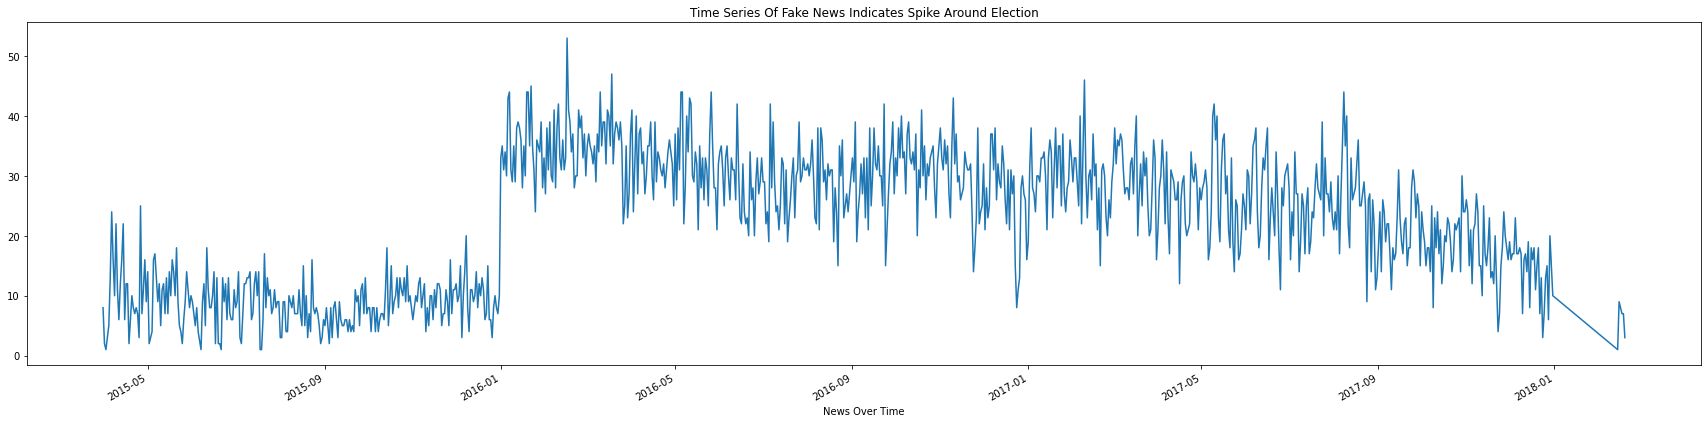

In [352]:
time_plots(Full_df.loc[Full_df['target']==1,:], title='Time Series Of Fake News Indicates Spike Around Election')

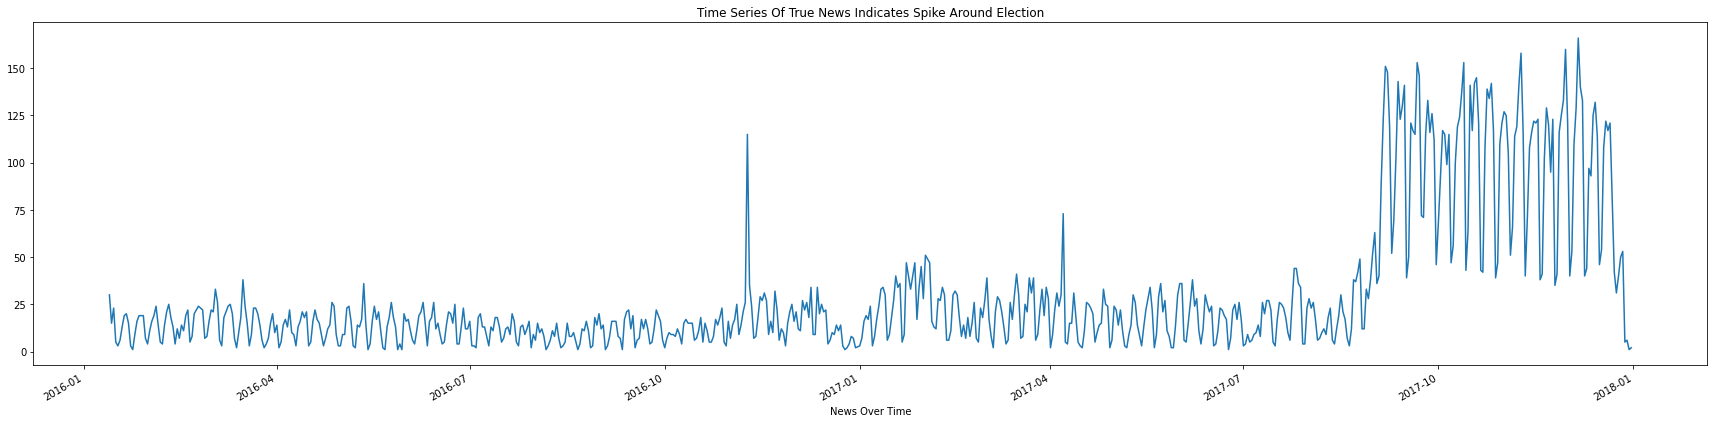

In [353]:
time_plots(Full_df.loc[Full_df['target']==0,:], title='Time Series Of True News Indicates Spike Around Election')

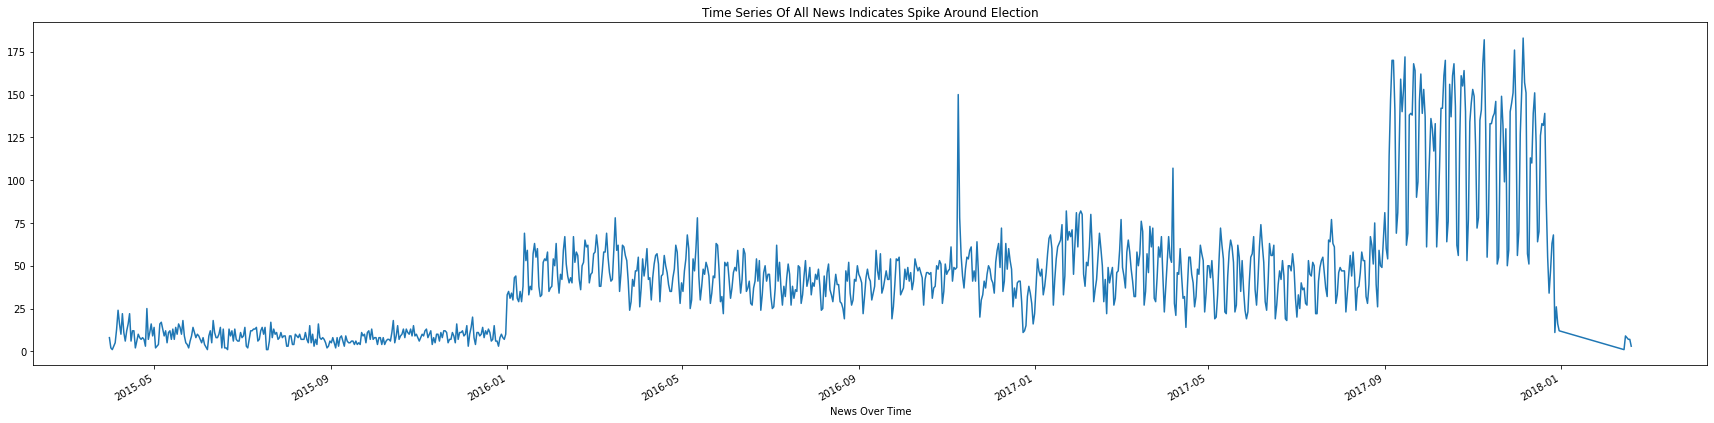

In [354]:
time_plots(Full_df, title='Time Series Of All News Indicates Spike Around Election')

In [355]:
def words_per_title(df):
    df["title_word_count"].value_counts(normalize=True).plot.bar(color='skyblue', figsize=[20,4]);


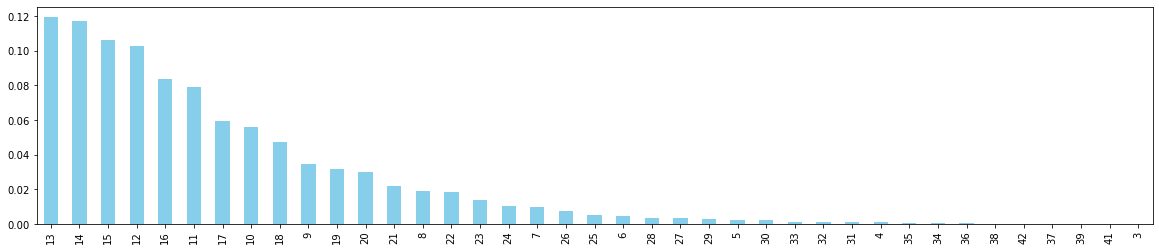

In [356]:
## Words per title in Fake News
words_per_title(Full_df[Full_df['target']==1])

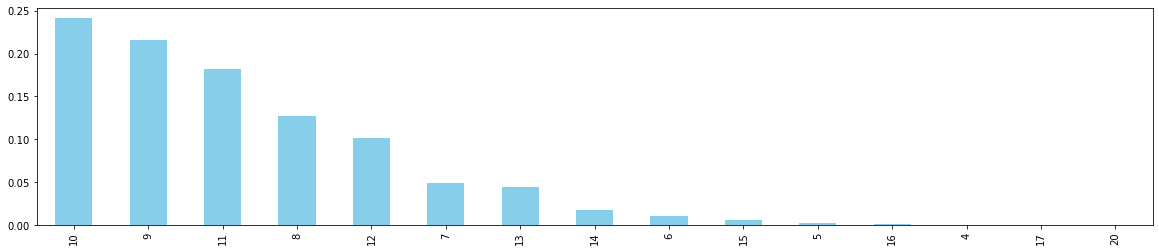

In [357]:
## Words per title in True News
words_per_title(Full_df[Full_df['target']==0])

In [358]:
## Create histogram for word/text count 
def plot_hist(series, title = None, xlab = None, ylab = None):
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title, fontsize = 12)
    plt.hist(series);

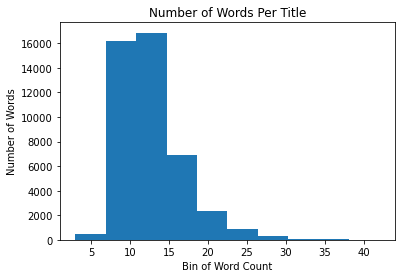

In [359]:
plot_hist(Full_df['title_word_count'], title = 'Number of Words Per Title', 
            xlab='Bin of Word Count', ylab= 'Number of Words')

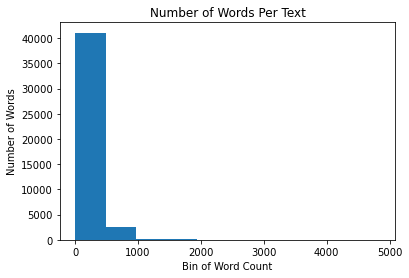

In [360]:
plot_hist(Full_df['text_word_count'], title = 'Number of Words Per Text', 
            xlab='Bin of Word Count', ylab= 'Number of Words')

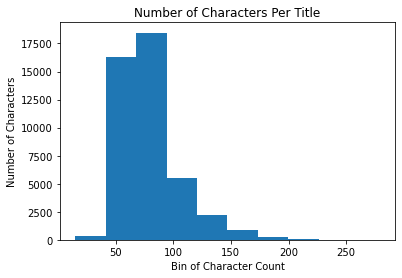

In [361]:
plot_hist(Full_df['title_char_length'], title = 'Number of Characters Per Title', 
            xlab='Bin of Character Count', ylab= 'Number of Characters')

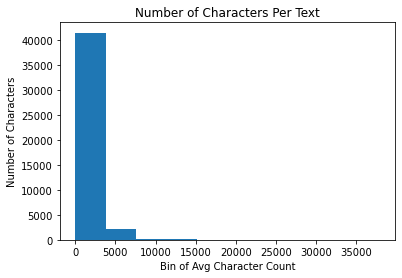

In [362]:
plot_hist(Full_df['text_char_length'], title = 'Number of Characters Per Text', 
        xlab='Bin of Avg Character Count', ylab= 'Number of Characters')

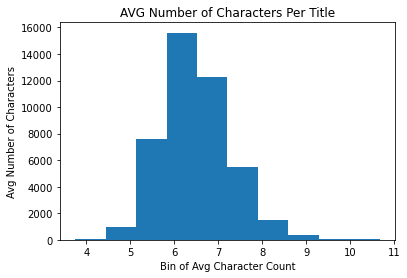

In [363]:
plot_hist(Full_df['char_per_word_title'], title = 'AVG Number of Characters Per Title', 
            xlab='Bin of Avg Character Count', ylab= 'Avg Number of Characters')

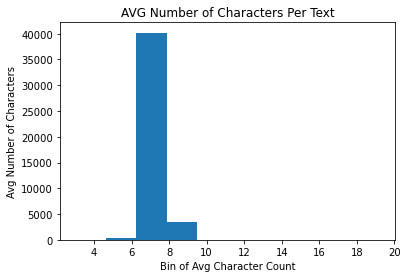

In [364]:
plot_hist(Full_df['char_per_word_text'], title = 'AVG Number of Characters Per Text', 
            xlab='Bin of Avg Character Count', ylab= 'Avg Number of Characters')

In [365]:
def fake_vs_true_hist(fake_series,true_series, title = None, log = False):
    if log == False:
        plt.hist((fake_series), alpha=0.5)
        plt.hist(true_series)
        plt.title(title)
        plt.tight_layout();
    else:
        plt.hist(np.log(fake_series), alpha=0.5)
        plt.hist(np.log(true_series))
        plt.title(title)
        plt.tight_layout();

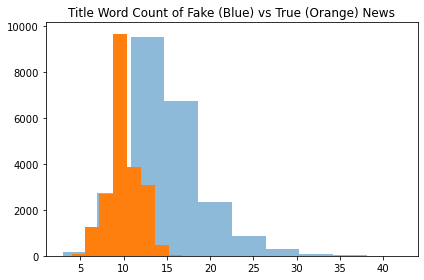

In [366]:
fake_vs_true_hist(fake_series=Full_df[Full_df["target"]==1]["title_word_count"], 
            true_series=Full_df[Full_df["target"]==0]["title_word_count"],
            title="Title Word Count of Fake (Blue) vs True (Orange) News")

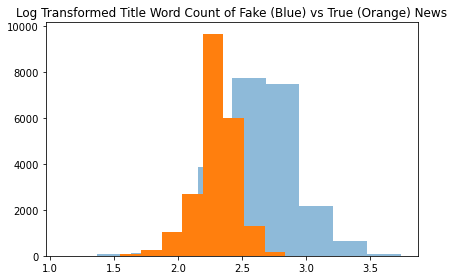

In [367]:
fake_vs_true_hist(fake_series=Full_df[Full_df["target"]==1]["title_word_count"], 
            true_series=Full_df[Full_df["target"]==0]["title_word_count"],
            title="Log Transformed Title Word Count of Fake (Blue) vs True (Orange) News", log=True)

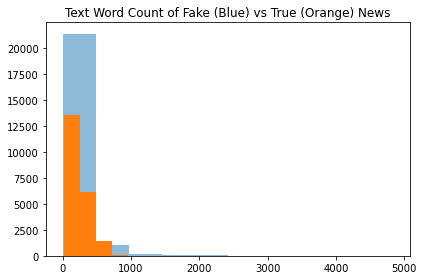

In [368]:
fake_vs_true_hist(fake_series=Full_df[Full_df["target"]==1]["text_word_count"], 
            true_series=Full_df[Full_df["target"]==0]["text_word_count"],
            title="Text Word Count of Fake (Blue) vs True (Orange) News")

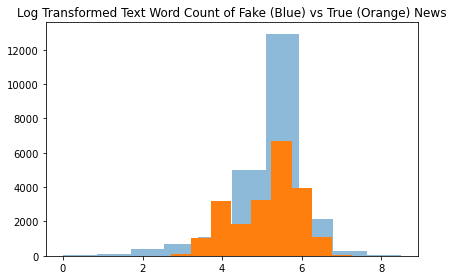

In [369]:
fake_vs_true_hist(fake_series=Full_df[Full_df["target"]==1]["text_word_count"], 
            true_series=Full_df[Full_df["target"]==0]["text_word_count"],
            title="Log Transformed Text Word Count of Fake (Blue) vs True (Orange) News", log=True)

In [370]:
# Function to reduce the redundancy of typing out this code. Use only for EDA. Fits and transform with cvec

def cvect_fit_transform(series, min_df = 1, max_df = 1, max_features = 5000, stop_words = ENGLISH_STOP_WORDS, ngram_range=(1,1)):
    if type(series) != pd.core.series.Series:
        return  "Not a Pandas Data Series"
    else:
        cvec = CountVectorizer(
                            min_df = min_df,
                            max_features = max_features,
                            stop_words = stop_words,
                            ngram_range=ngram_range
                        )
        # Fit our vectorizier on our corpus
        cvec.fit(series)
        # Transform the corpus
        df_txt = cvec.transform(series)
        # Put data into a Data Frame format
        df_txt = pd.DataFrame(df_txt.todense(), 
                          columns=cvec.get_feature_names_out())
        return df_txt 

In [371]:
# Function to reduce the redundancy of typing out this code. Use only for EDA. 
# Uses cvec_fit_transform df to create visualizations

def cvec_bar_plots(gram_model, title = None, xlab = "Frequency", xlabsize = 10, ylab = None, ylabsize = 10, figsize = (15,10), tsize = 20, headsize = 25, barcolor = 'skyblue'):
    plt.figure(figsize = figsize)
    gram_model.sum().sort_values(ascending=False).head(headsize).plot(kind='barh', color=barcolor)
    plt.title(title, c='black', horizontalalignment='center', fontdict= {'size': tsize})
    plt.ylabel(ylab, size=ylabsize, c='black')
    plt.xlabel(xlab, c="black", fontdict= {'size': xlabsize})
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

# xlabel and y label naming convention from GA Linear Time Series Modeling lesson

#### Custom Stop Words

In [372]:
# To be Finalized
# y_words=["said",'trump','reuters', 'hilary', "president", "united", "states", "state", "government", "getty images", "people", "told", "people", "percent", "featured news" ]
# my_stop_words=ENGLISH_STOP_WORDS.union(my_words)

##### Unigram - Fake News Set

In [373]:
Fake_df_txt=Full_df[Full_df['target']==1]['text']

In [374]:
Fake_df_txt_cvec = cvect_fit_transform(Fake_df_txt, min_df = 3, max_df = 1, max_features = 5000, 
                    stop_words = ENGLISH_STOP_WORDS, ngram_range=(1,1))

In [375]:
Fake_df_txt_cvec.head()

,00,000,10,100,11,12,13,14,15,150,...,yiannopoulos,york,young,younger,youth,youtu,youtube,zero,zone,zones
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


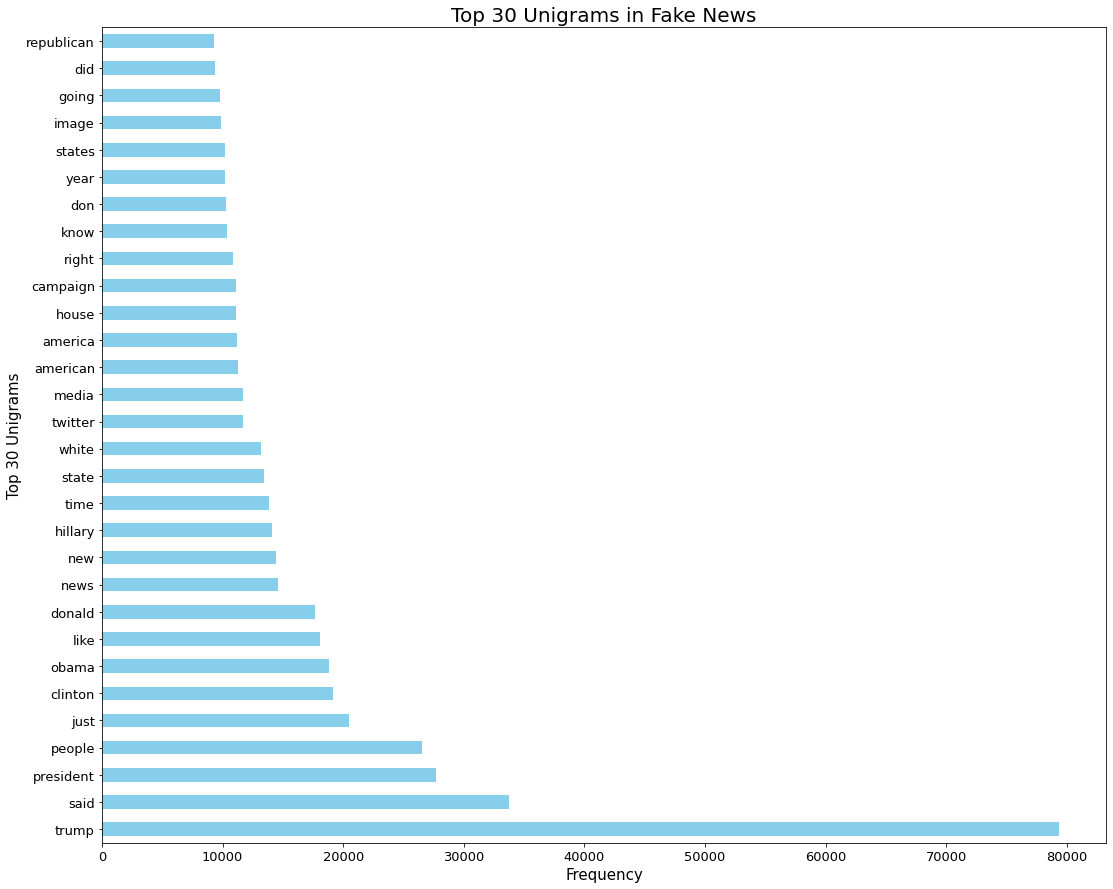

In [376]:
cvec_bar_plots(Fake_df_txt_cvec, title="Top 30 Unigrams in Fake News", 
            ylab="Top 30 Unigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

##### Unigram - True News Set

In [377]:
True_df_txt=Full_df[Full_df['target']==0]['text']

In [378]:
True_df_txt_cvec = cvect_fit_transform(True_df_txt, min_df = 3, max_df = 1, max_features = 5000, 
                    stop_words = ENGLISH_STOP_WORDS, ngram_range=(1,1))

In [379]:
True_df_txt_cvec.head()

,000,10,100,11,12,120,13,130,14,15,...,zealand,zeid,zero,zika,zimbabwe,zinke,zone,zones,zor,zuma
0,0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


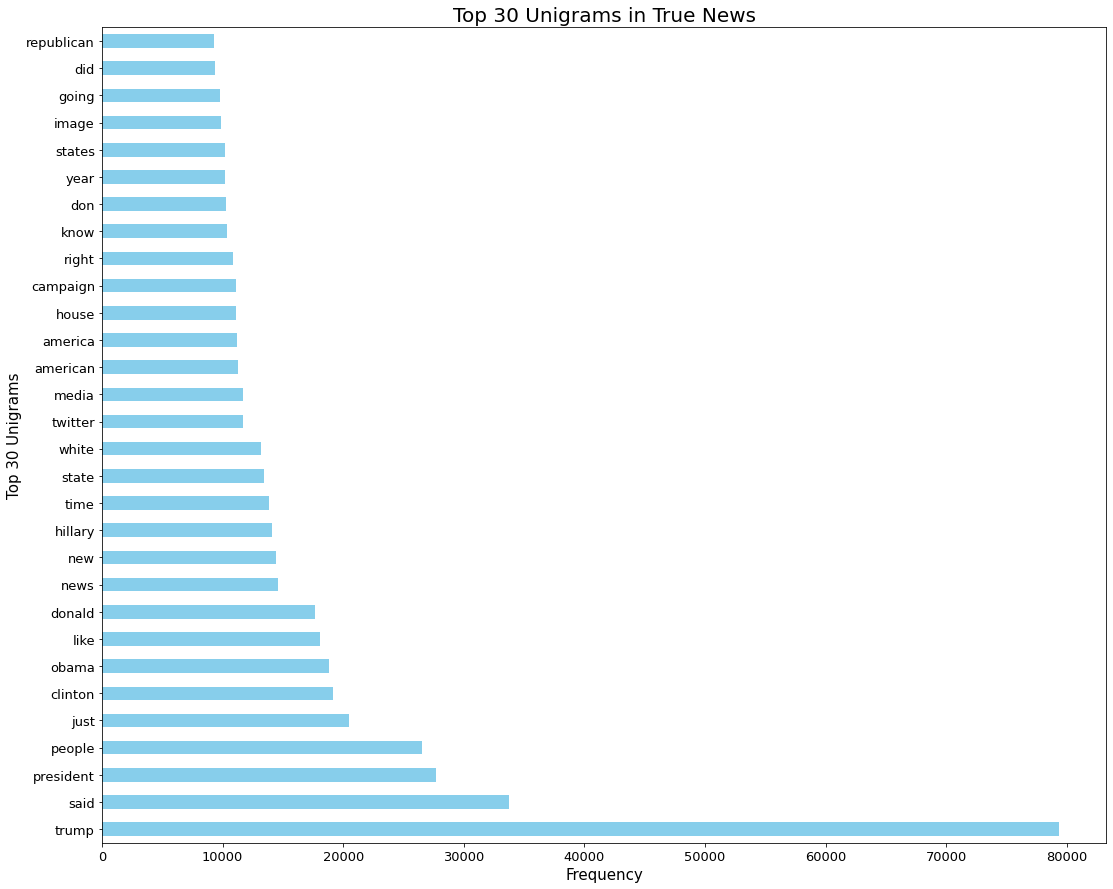

In [380]:
cvec_bar_plots(Fake_df_txt_cvec, title="Top 30 Unigrams in True News", 
            ylab="Top 30 Unigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

#### Unigram - Full Set

In [381]:
Full_df_txt=Full_df['text']

In [382]:
Full_df_txt_cvec = cvect_fit_transform(Full_df_txt, min_df = .02, max_df = 1, max_features = 5000, 
                    stop_words = ENGLISH_STOP_WORDS, ngram_range=(1,1))

In [383]:
Full_df_txt_cvec

,000,10,100,11,12,13,14,15,16,17,...,wrong,wrote,year,years,yes,yesterday,york,young,youtube,zone
0,0,0,0,1,0,0,0,0,0,0,...,1,0,15,3,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43965,2,0,0,1,1,0,0,1,1,0,...,0,0,1,1,0,1,0,0,0,0
43966,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
43967,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,0,0,0,0,0,0
43968,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


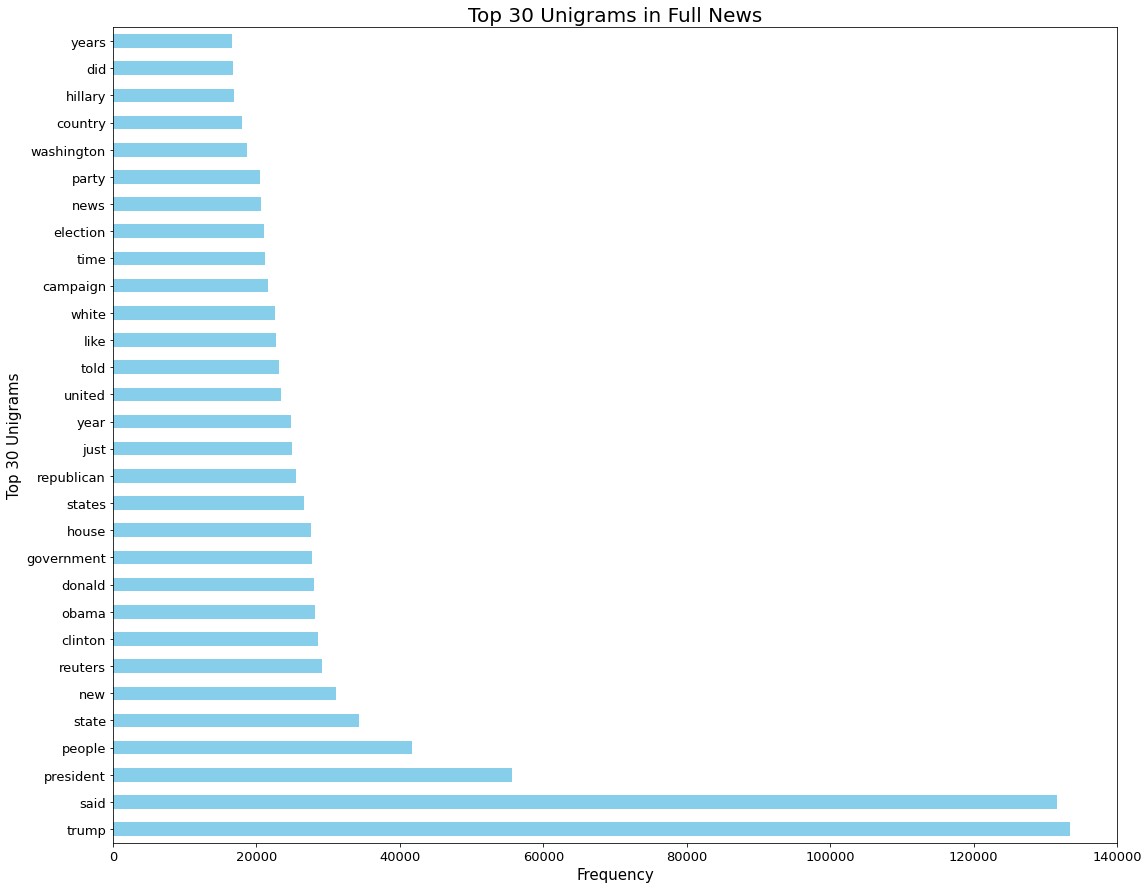

In [384]:
cvec_bar_plots(Full_df_txt_cvec, title="Top 30 Unigrams in Full News", 
            ylab="Top 30 Unigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

##### Bigram - Fake News Set

In [385]:
Fake_df_txt_bi_cvec = cvect_fit_transform(Fake_df_txt, min_df = .02, max_df = 1, max_features = 5000, 
                    stop_words = 'english', ngram_range=(2,2))

In [386]:
Fake_df_txt_bi_cvec.head()

,2016 election,21st century,21wire subscribe,21wire tv,african american,american people,anti trump,attorney general,barack obama,bernie sanders,...,washington post,watch video,white house,wire says,www youtube,year old,years ago,york city,york times,youtube com
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


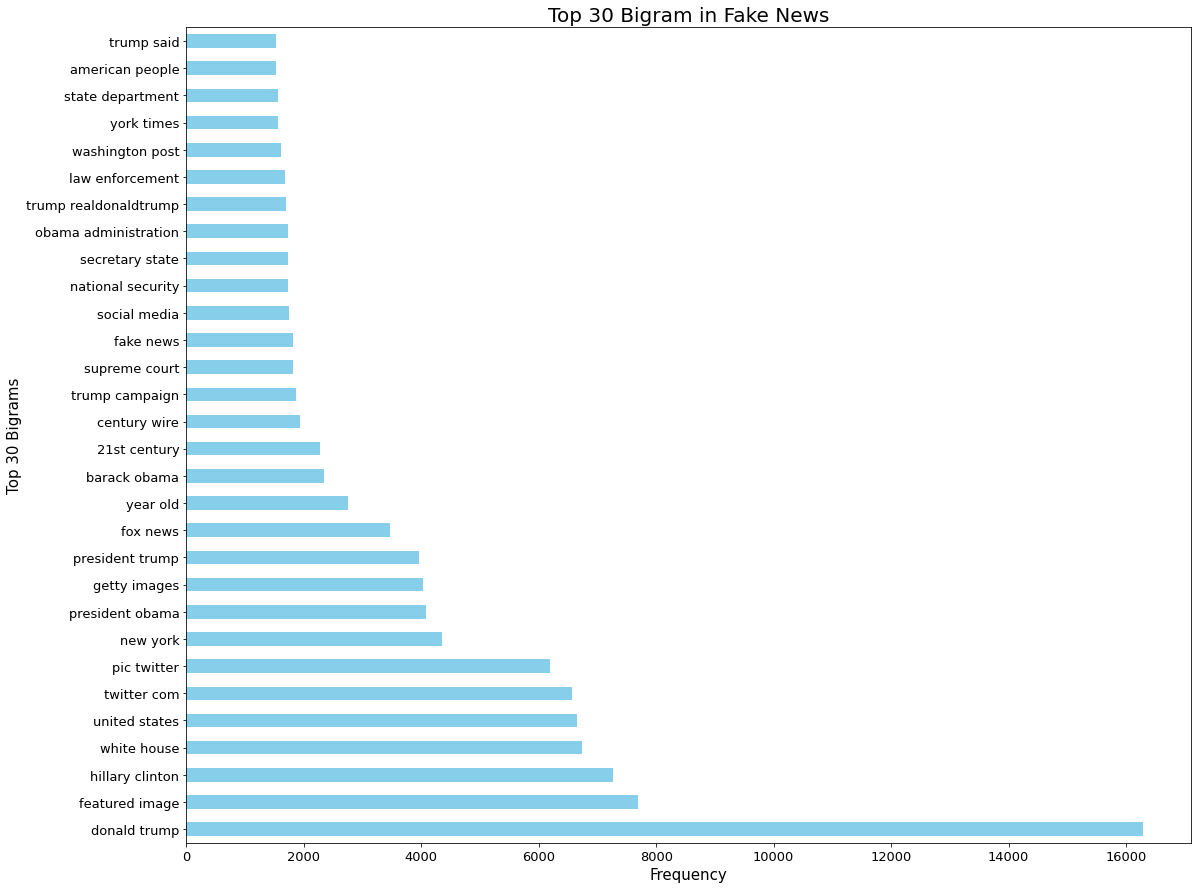

In [387]:
cvec_bar_plots(Fake_df_txt_bi_cvec, title="Top 30 Bigram in Fake News", 
            ylab="Top 30 Bigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

##### Bigram - True News Set

In [388]:
True_df_txt_bi_cvec = cvect_fit_transform(True_df_txt, min_df = .02, max_df = 1, max_features = 5000, 
                    stop_words = 'english', ngram_range=(2,2))

In [389]:
True_df_txt_bi_cvec.head()

,000 people,2016 election,2016 presidential,angela merkel,attorney general,ballistic missile,barack obama,beijing reuters,berlin reuters,bernie sanders,...,vice president,vladimir putin,wall street,washington reuters,white house,xi jinping,year old,years ago,york reuters,york times
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


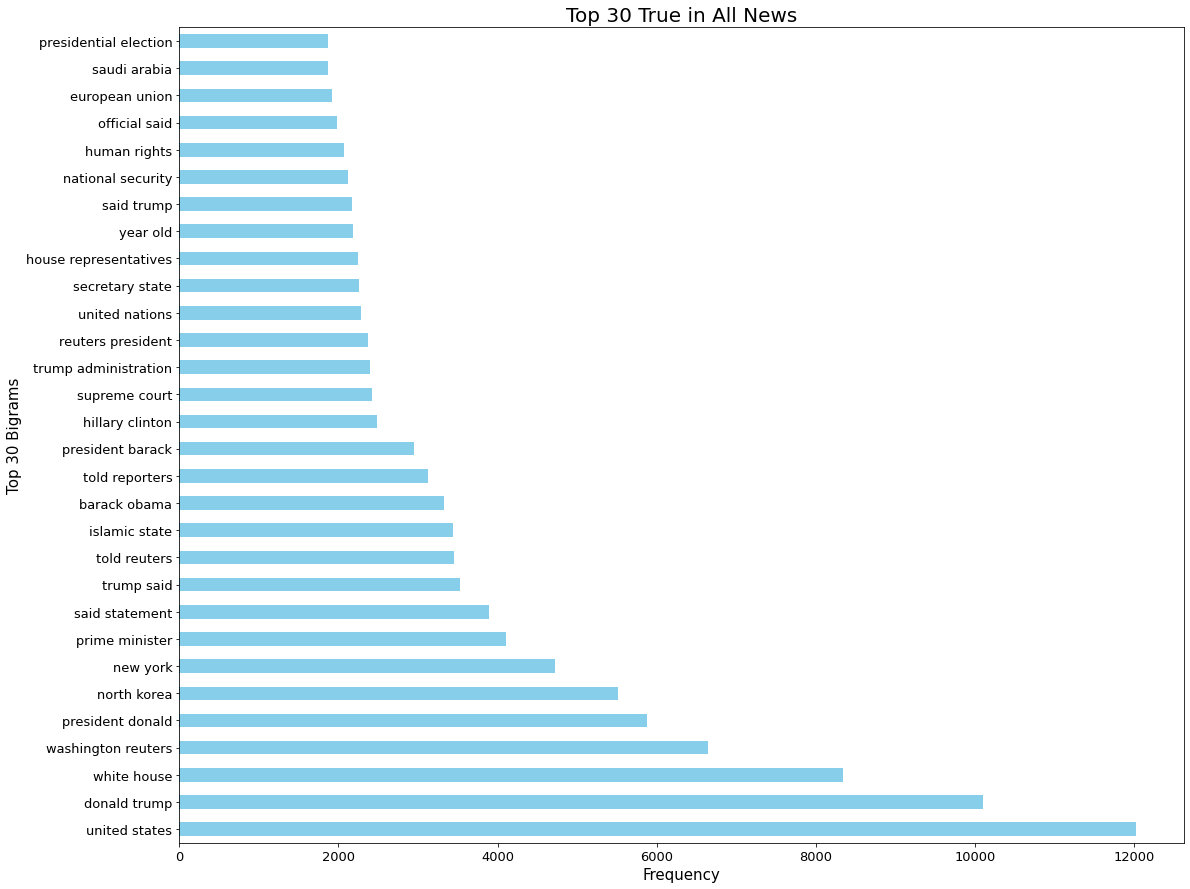

In [390]:
cvec_bar_plots(True_df_txt_bi_cvec, title="Top 30 True in All News", 
            ylab="Top 30 Bigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

#### Bigrams - Full Set

In [391]:
Full_df_txt_bi_cvec = cvect_fit_transform(Full_df_txt, min_df = .02, max_df = 1, max_features = 5000, 
                    stop_words = 'english', ngram_range=(2,2))

In [392]:
Full_df_txt_bi_cvec.head()

,000 people,2016 election,2016 presidential,21st century,american people,attorney general,barack obama,bernie sanders,century wire,climate change,...,united states,vice president,vladimir putin,wall street,washington post,washington reuters,white house,year old,years ago,york times
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


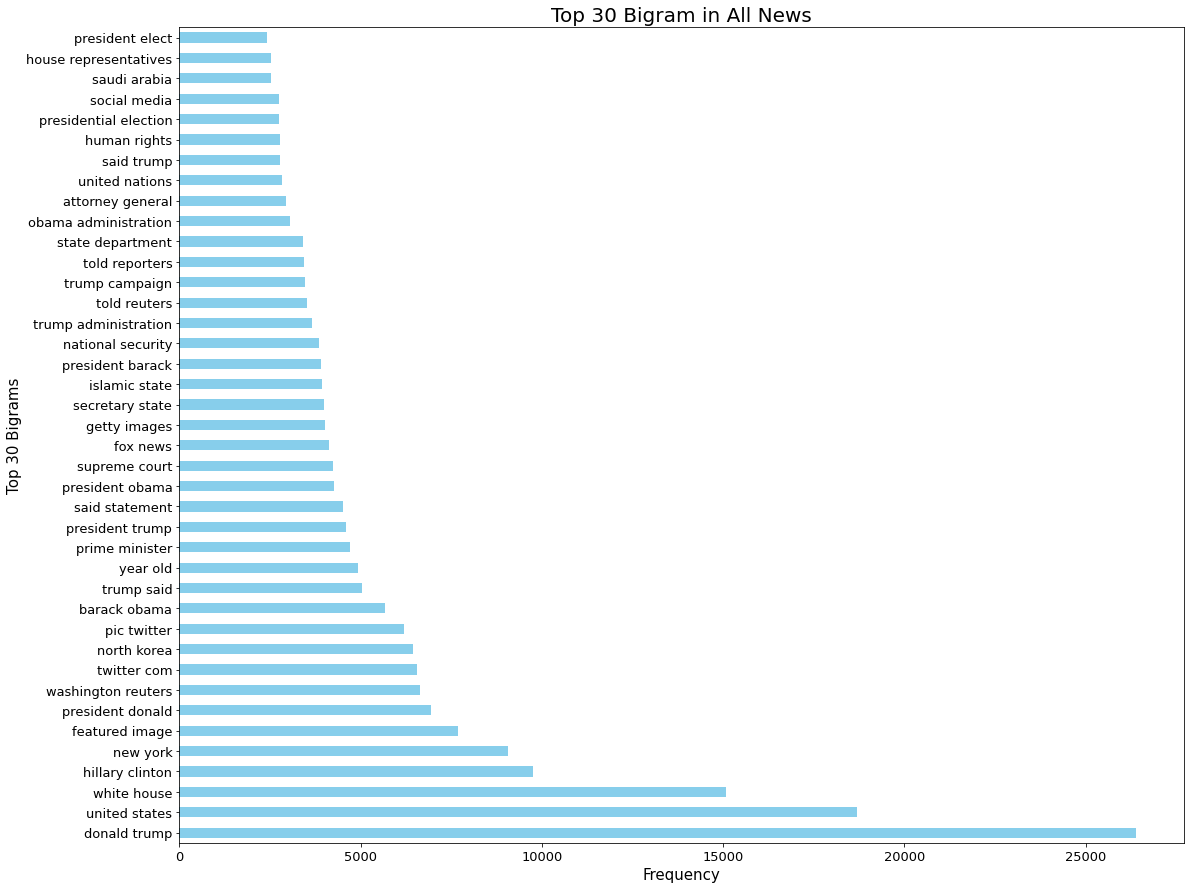

In [393]:
cvec_bar_plots(Full_df_txt_bi_cvec, title="Top 30 Bigram in All News", 
            ylab="Top 30 Bigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=40)

#### Trigrams - Fake News Set

In [394]:
Fake_df_txt_tri_cvec = cvect_fit_transform(Fake_df_txt, min_df = .002, max_df = 1, max_features = 5000, 
                    stop_words = 'english', ngram_range=(3,3))

In [395]:
Fake_df_txt_tri_cvec.head()

,00 pm cst,00 pm est,00 pm pst,038 version v2,10 year old,11 year old,12 year old,13 year old,14 year old,15 year old,...,year old woman,york city mayor,york daily news,york times reported,york times reports,york times washington,youtube com watch,youtube donald trump,youtube https www,zone listen player
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


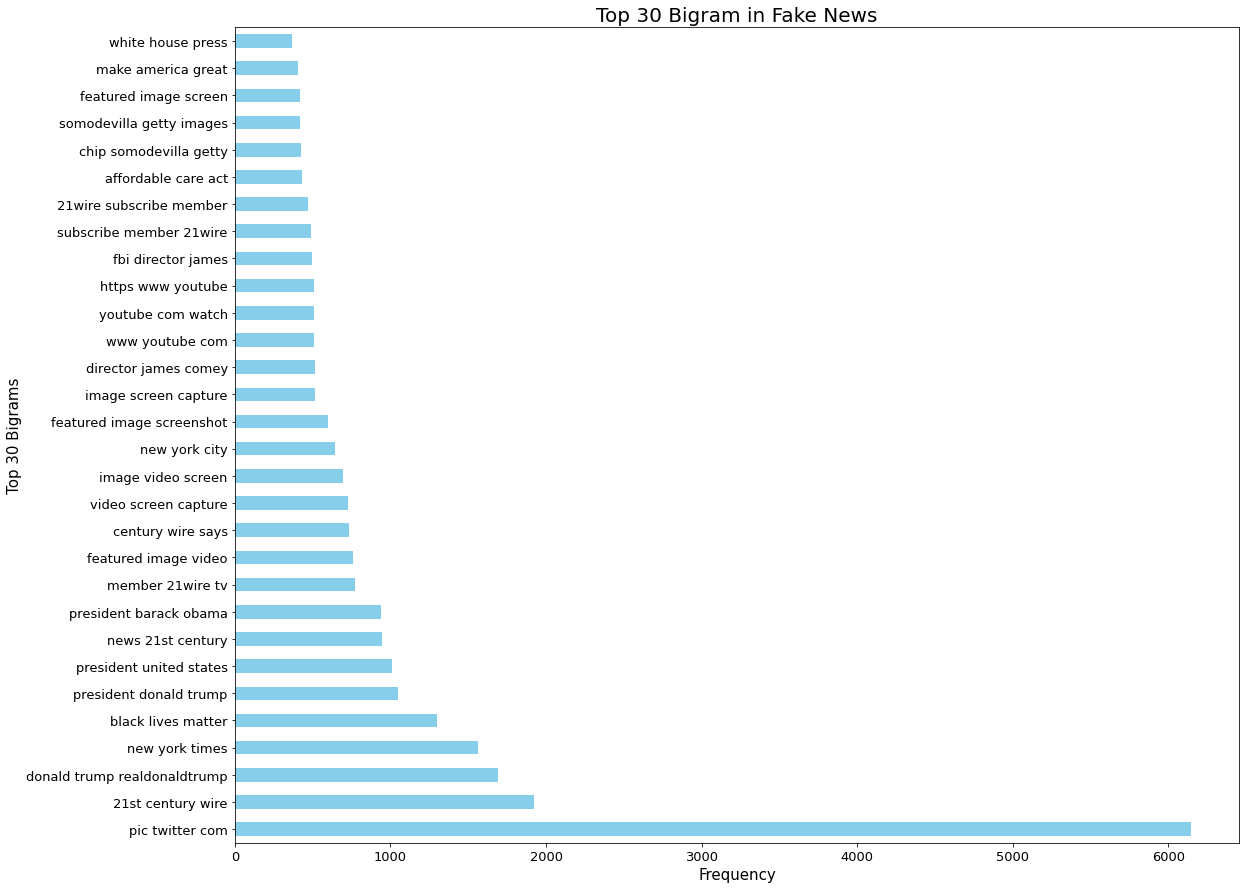

In [396]:
cvec_bar_plots(Fake_df_txt_tri_cvec, title="Top 30 Bigram in Fake News", 
            ylab="Top 30 Bigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

#### Trigrams - True News Set

In [397]:
True_df_txt_tri_cvec = cvect_fit_transform(True_df_txt, min_df = .01, max_df = 1, max_features = 5000, 
                    stop_words = 'english', ngram_range=(3,3))

In [398]:
True_df_txt_tri_cvec.head()

,2016 presidential election,affordable care act,american free trade,attorney general jeff,bashar al assad,british prime minister,candidate donald trump,candidate hillary clinton,chancellor angela merkel,chinese president xi,...,vice president mike,washington reuters house,washington reuters president,washington reuters republican,washington reuters senate,washington reuters white,white house official,white house said,white house spokesman,white house spokeswoman
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


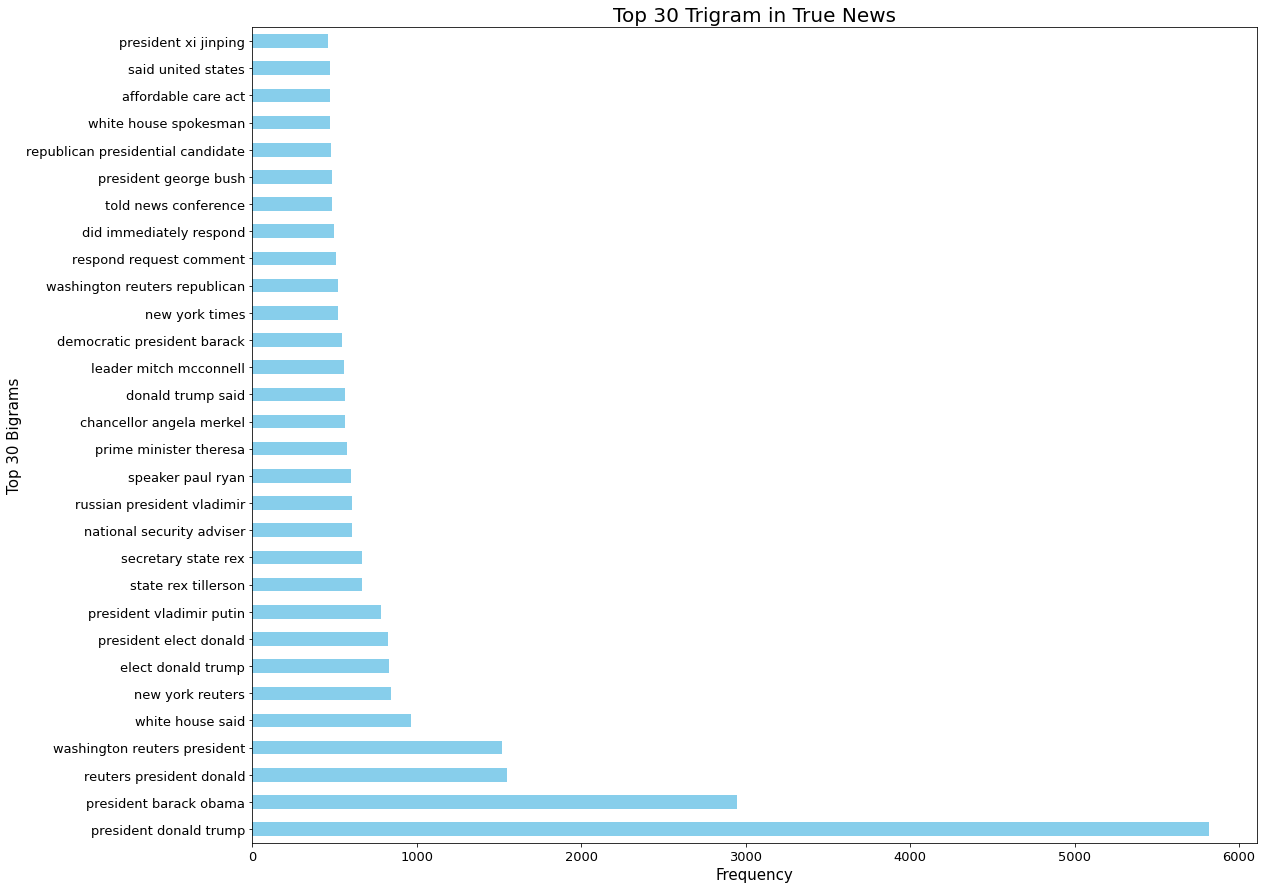

In [399]:
cvec_bar_plots(True_df_txt_tri_cvec, title="Top 30 Trigram in True News", 
            ylab="Top 30 Bigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

#### Trigrams - Full News Set

In [400]:
Full_df_txt_tri_cvec = cvect_fit_transform(Full_df_txt, min_df = .01, max_df = 1, max_features = 5000, 
                    stop_words = 'english', ngram_range=(3,3))

In [401]:
Full_df_txt_tri_cvec.head()

,2016 presidential election,21st century wire,21wire subscribe member,affordable care act,bashar al assad,black lives matter,candidate donald trump,candidate hillary clinton,century wire says,chancellor angela merkel,...,trump white house,vice president mike,video screen capture,wall street journal,washington reuters president,washington reuters republican,white house said,white house spokesman,www youtube com,youtube com watch
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


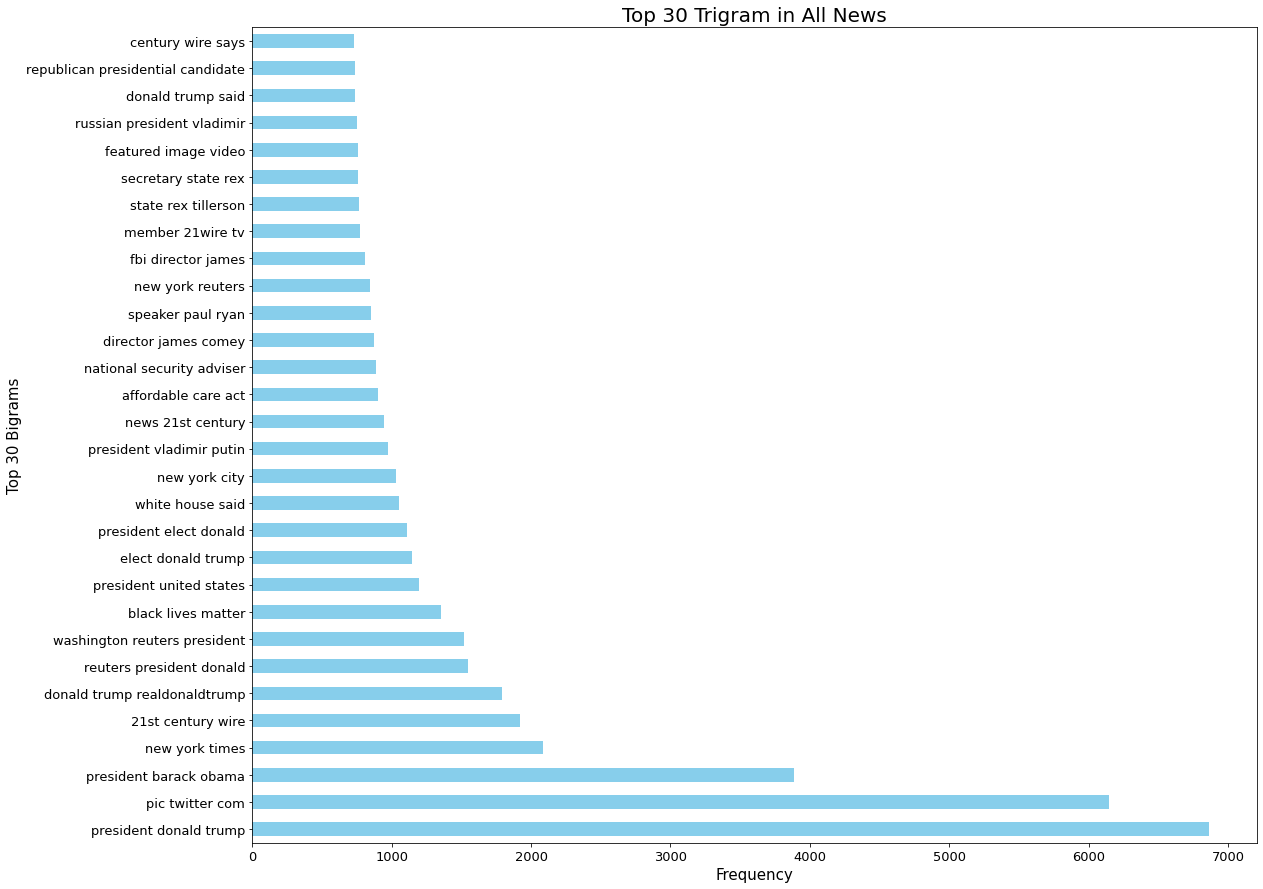

In [402]:
cvec_bar_plots(Full_df_txt_tri_cvec, title="Top 30 Trigram in All News", 
            ylab="Top 30 Bigrams", xlabsize = 15, ylabsize=15, figsize= (18,15), headsize=30)

# Modeling